In [101]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from helper_functions.flow_data_discretization import *

data = pd.read_pickle('./data/scenario_10.pkl')
data.head()

data_nobground = data[data['Label']!='Background']

infected_hosts = ['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.204',
                  '147.32.84.205','147.32.84.206','147.32.84.207','147.32.84.208','147.32.84.209']

In [2]:
data_infected = data_nobground[data_nobground['Src_IP_Addr']==infected_hosts[0]]
data_clean = data_nobground[data_nobground['Src_IP_Addr']!=infected_hosts[0]]

In [3]:
infected_code = np.load('./data/infected_code.npy', allow_pickle=True)
infected_labels = np.ones(len(infected_code), dtype=int)

test_code = np.load('data/test_code.npy', allow_pickle=True)
test_labels = np.load('data/test_labels.npy', allow_pickle=True)

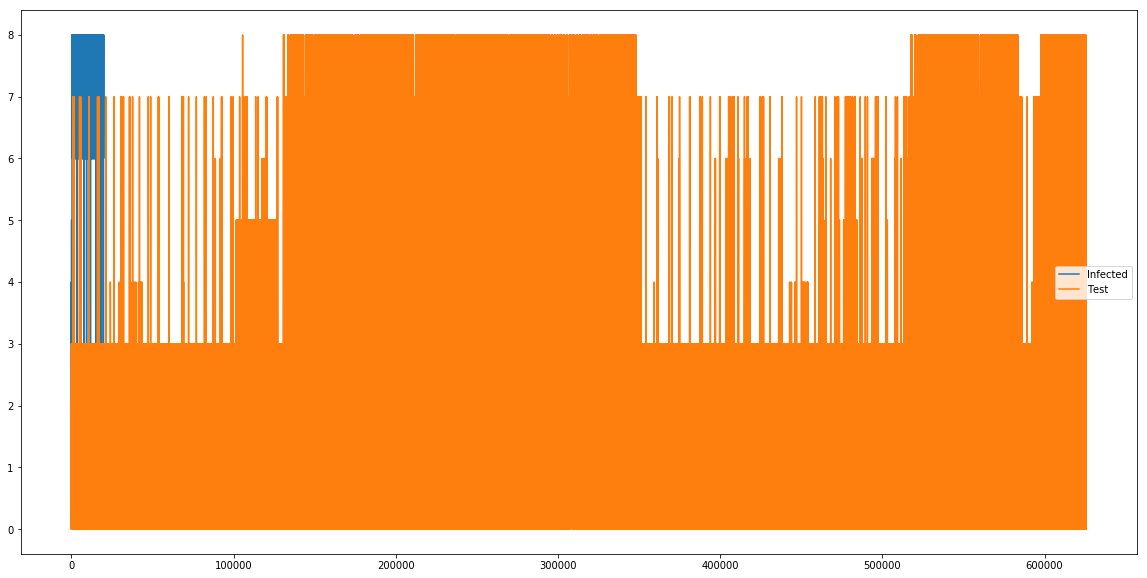

In [4]:
plt.figure(figsize=(20,10))
plt.plot(infected_code, label = 'Infected')
plt.plot(test_code, label= 'Test')
plt.legend()

In [40]:
l = len(infected_code)
n = 3
if l%n==0:
    ngrams = np.reshape(infected_code, [l//n, n])
else:
    ngrams = np.reshape(infected_code[:-(l%n)], [(l-l%n)//n, n])

In [4]:
def extract_ngrams(data, n):
    l = len(data)
    if l%n==0:
        ngrams = np.reshape(data, [l//n, n])
    else:
        ngrams = np.reshape(data[:-(l%n)], [(l-l%n)//n, n])
        
    return ngrams

In [103]:
trigrams = extract_ngrams(infected_code, 3)
unique_trigrams, trigrams_counts = np.unique(trigrams, axis=0, return_counts=True)
trigrams_prob = trigrams_counts/sum(trigrams_counts)

bigrams = extract_ngrams(infected_code, 2)
unique_bigrams, bigrams_counts = np.unique(bigrams, axis=0, return_counts=True)

In [6]:
prob = np.zeros(len(trigrams))
i = 0
for ii in trigrams:
    b_ind = np.where(np.prod(np.equal(ii[:-1], unique_bigrams), axis=1))
    t_ind = np.where(np.prod(np.equal(ii, unique_trigrams), axis=1))
#     print("Trigram: ", ii)
#     print("Unique Trigram: ", unique_trigrams[t_ind])
#     print("Unique Bigrams: ", unique_bigrams[b_ind], "\n")
    prob[i] = trigrams_counts[t_ind]/bigrams_counts[b_ind]
    
    i=i+1
    

In [35]:
counts = data_clean.groupby(by='Src_IP_Addr').size()
counts

Src_IP_Addr
10.10.20.233       75
10.168.115.232      5
10.168.48.160       4
10.23.106.55        2
10.23.12.43         4
10.23.130.74        5
10.23.139.192       5
10.23.20.92         4
10.23.24.236        3
10.23.60.88         4
10.23.64.58         3
10.28.118.2         4
10.28.160.211       2
10.28.31.72         4
10.28.48.34         3
109.183.212.229     2
109.205.72.182      2
109.230.222.33      4
114.80.93.71        6
117.241.11.209      8
119.63.196.103      1
119.63.196.12       2
119.63.196.45       2
119.63.196.49       2
119.63.196.52       2
119.63.196.55       2
119.63.196.82       2
119.63.196.83       2
119.63.196.84       2
119.63.196.90       2
                   ..
90.178.18.205       3
90.178.200.35       2
90.179.148.10       4
90.182.1.249       12
90.182.139.202      2
90.183.220.145      3
90.183.239.162      2
90.183.39.17       14
90.40.213.8        25
91.103.160.39       4
91.103.160.56      33
91.202.144.77       1
91.82.255.135       2
92.123.64.137      1

In [83]:
hosts = np.unique(data_clean['Src_IP_Addr'].values)
ordinal_val = [1]
feat = ['Prot', 'Packets']
n=3

pred = np.zeros(len(hosts), dtype=int)
i=0
for host in hosts:
    host_data = data_clean[data_clean['Src_IP_Addr']==host]
    if len(host_data)<n:
        continue
    host_data = host_data[feat].values
    host_data[:,1] = discretize_ordinal(host_data[:,1], ordinal_val)
    
    host_code, _ = extract_code(host_data)
    host_ngrams = extract_ngrams(host_code, 3)
    host_alarms = []
    for ngram in host_ngrams:
        if np.sum(np.prod(np.equal(ngram, unique_trigrams), axis=1))==0:
            host_alarms.append(ngram)
    if len(host_alarms)!=0:
        pred[i]=1
    
    i = i+1

In [102]:
TP = np.sum(np.isin(hosts[pred==1], infected_hosts))
FP = np.sum(pred==1) - TP
TN = np.sum(np.isin(hosts[pred==0], infected_hosts, invert=True))
FN = np.sum(pred==0) - TN
print("TP: ", TP)
print("FP: ", FP)
print("FN: ", FN)
print("TN:", TN)
print(TP+FP+TN+FN)

TP:  7
FP:  161
FN:  2
TN: 351
521


In [104]:
hosts = np.unique(data_clean['Src_IP_Addr'].values)
ordinal_val = [1]
feat = ['Prot', 'Packets']
n=3

pred = np.zeros(len(hosts), dtype=int)
i=0
for host in hosts:
    host_data = data_clean[data_clean['Src_IP_Addr']==host]
    if len(host_data)<n:
        continue
    host_data = host_data[feat].values
    host_data[:,1] = discretize_ordinal(host_data[:,1], ordinal_val)
    
    host_code, _ = extract_code(host_data)
    host_ngrams = extract_ngrams(host_code, 3)
    host_unique_ngrams, host_count = np.unique(host_ngrams, axis=0, return_counts=True)
    host_prob = host_count/np.sum(host_count)
    host_alarms = host_prob < min(trigrams_prob)
#     host_alarms = []
#     for ngram in host_ngrams:
#         if np.sum(np.prod(np.equal(ngram, unique_trigrams), axis=1))==0:
#             host_alarms.append(ngram)
    if len(host_alarms)!=0:
        pred[i]=1
    
    i = i+1

In [105]:
TP = np.sum(np.isin(hosts[pred==1], infected_hosts))
FP = np.sum(pred==1) - TP
TN = np.sum(np.isin(hosts[pred==0], infected_hosts, invert=True))
FN = np.sum(pred==0) - TN
print("TP: ", TP)
print("FP: ", FP)
print("FN: ", FN)
print("TN:", TN)
print(TP+FP+TN+FN)

TP:  9
FP:  388
FN:  0
TN: 124
521
